## This notebook shows how to use `grizli` to

model contamination + continuum + emission for G102/G141 observations of a single object in the CLEAR GS1 field. The final products are 1D and 2D spectra and line maps.

These series of notebooks draw heavily from Gabe Brammer's existing `grizli` notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with examples specific for the CLEAR survey.

In [1]:
%matplotlib inline
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import drizzlepac
import grizli
import glob
from grizli import utils
import importlib
from grizli.prep import process_direct_grism_visit
from hsaquery import query, overlaps
from grizli.pipeline import auto_script
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import os
from grizli.pipeline import photoz
from astropy.table import Table
import eazy
from IPython.display import Image


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


### The results of this notebook are available for download on the team archive (Prep_premade_GS1.tar.gz):

https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/





### ***The following paths need to be changed for your filesystem.*** [HOME_PATH] is where the raw data, reduced data, and `grizli` outputs will be stored. [PATH_TO_CATS] is where the catalogs are stored and must include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
        
the [PATH_TO_CATS] files are available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/

In [2]:
field           = 'GS1'
ref_filter      = 'F105W'
HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_SCRIPTS = '/Users/rsimons/Desktop/git/clear_local/example_notebooks'
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'
PATH_TO_RAW     = glob.glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob.glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500 # really only necessary for GDN
            self.radec_catalog = PATH_TO_CATS + '/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')



In [3]:
os.chdir(PATH_TO_PREP)
files = glob.glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [4]:
product_names = np.array([visit['product'] for visit in visits])
filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])


In [5]:
all_grism_files = []
all_direct_files = []

ref_filter_1 = 'F105W' 
ref_filter_2 = 'F140W'

ref_grism_1 = 'G102'
ref_grism_2 = 'G141'

for v, visit in enumerate(visits):
    product = product_names[v]
    basename = basenames[v]
    filt1 = filter_names[v]
    if (ref_filter_1.lower() in filt1) or (ref_filter_2.lower() in filt1):
        all_direct_files.extend(visit['files'])
        grism_index_1 = np.where((basenames == basename) & (filter_names == ref_grism_1.lower()))[0]
        grism_index_2 = np.where((basenames == basename) & (filter_names == ref_grism_2.lower()))[0]
        if len(grism_index_1) > 0:
            all_grism_files.extend(visits[grism_index_1[0]]['files'])
        if len(grism_index_2) > 0:
            all_grism_files.extend(visits[grism_index_2[0]]['files'])
        
print ('Number of direct files:', len(all_direct_files))
print ('Number of grism files:', len(all_grism_files))


Number of direct files: 16
Number of grism files: 28


<h1><center>Contamination models</center></h1>

The contamination models have been pre-made and can be downloaded from (Prep_premade_GS1.tar.gz):

https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/

untar the file

    tar -xzvf Prep_premade_GS1.tar.gz
    
and move the *GrismFLT.pkl and *GrismFLT.fits files to your working PREP/ directory.


In [6]:
p = Pointing(field = field, ref_filter = ref_filter_1)
print('Initializing (or loading pre-existing) contamination models...')

grp = GroupFLT(grism_files=all_grism_files, 
               direct_files=[], 
               ref_file = p.ref_image,
               seg_file = p.seg_map,
               catalog  = p.catalog,
               pad=p.pad,
               cpu_count=8)

Initializing (or loading pre-existing) contamination models...
Load ibhj01iqq.01.GrismFLT.fits!
Load ibhj01ixq.01.GrismFLT.fits!
Load ibhj01j4q.01.GrismFLT.fits!
Load ibhj01jbq.01.GrismFLT.fits!
Load icxt09f0q.01.GrismFLT.fits!
Load icxt09f2q.01.GrismFLT.fits!
Load icxt09f5q.01.GrismFLT.fits!
Load icxt09f7q.01.GrismFLT.fits!
Load icxt10dbq.01.GrismFLT.fits!
Load icxt10deq.01.GrismFLT.fits!
Load icxt10diq.01.GrismFLT.fits!
Load icxt10dkq.01.GrismFLT.fits!
Load icxt07dxq.01.GrismFLT.fits!
Load icxt07dzq.01.GrismFLT.fits!
Load icxt07e2q.01.GrismFLT.fits!
Load icxt07e4q.01.GrismFLT.fits!
Load icxt08e7q.01.GrismFLT.fits!
Load icxt08e9q.01.GrismFLT.fits!
Load icxt08ecq.01.GrismFLT.fits!
Load icxt08eeq.01.GrismFLT.fits!
Load icxt11qiq.01.GrismFLT.fits!
Load icxt11qkq.01.GrismFLT.fits!
Load icxt11qnq.01.GrismFLT.fits!
Load icxt11qpq.01.GrismFLT.fits!
Load icxt12qvq.01.GrismFLT.fits!
Load icxt12qxq.01.GrismFLT.fits!
Load icxt12r0q.01.GrismFLT.fits!
Load icxt12r2q.01.GrismFLT.fits!
Files loaded 

### Creating new contamination models

In [7]:
compute_models = False
if compute_models:
    print('Computing first-pass contamination models...')
    grp.compute_full_model(mag_limit = 25)

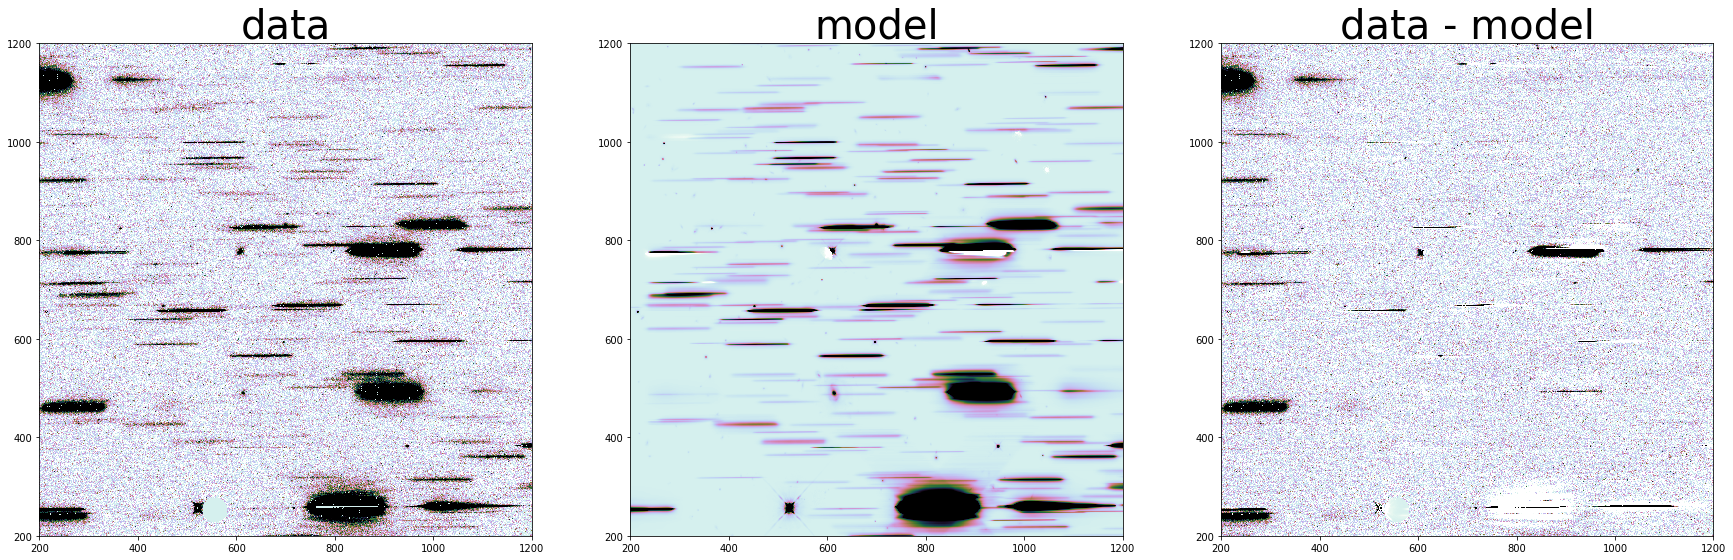

In [8]:
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')

axes[0].set_title('data', fontsize = 40)
axes[1].set_title('model', fontsize = 40)
axes[2].set_title('data - model', fontsize = 40)

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    



In [9]:
if compute_models:
    print('Re-computing continuum models, but with higher-order polynomials..')
    grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

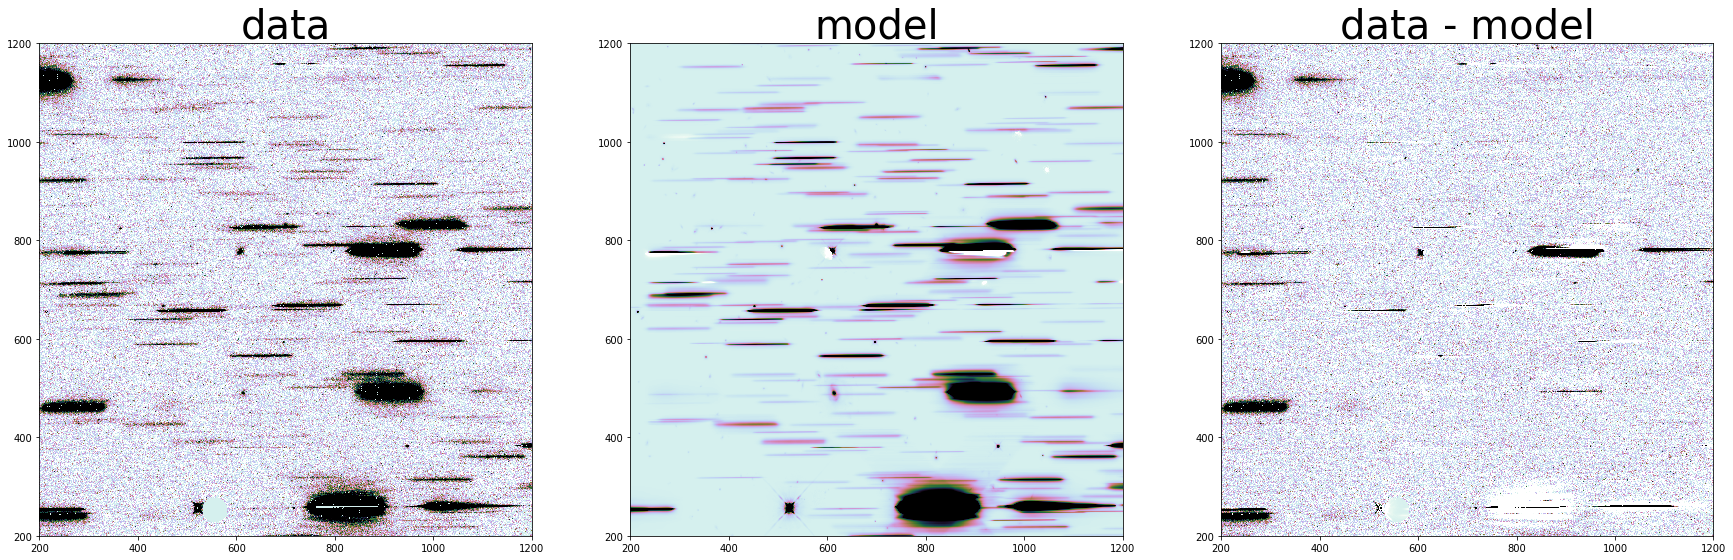

In [10]:
fig.clf()
fig, axes = plt.subplots(1,3, figsize=[30,10])
axes[0].imshow(grp.FLTs[0].grism['SCI'], vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[1].imshow(grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[2].imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',interpolation='Nearest', origin='lower')
axes[0].set_title('data', fontsize = 40)
axes[1].set_title('model', fontsize = 40)
axes[2].set_title('data - model', fontsize = 40)

for ax in axes:
    ax.set_xlim(200,1200) 
    ax.set_ylim(200,1200)
    
    

In [11]:
if compute_models:
    print('Saving contamination models')
    grp.save_full_data()


<h1><center>Fitting a single object, ID = 43404 </center></h1>

### Load internal SED templates

In [12]:
# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes

templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

fmt = '{0:<36s} {1:<36s}'
print(fmt.format('templ0', 'templ1'))
print(fmt.format('------', '------'))

for i in range(len(templ1)):
    if i > len(templ0)-1:
        print(fmt.format('', list(templ1.keys())[i]))
    else:
        print(fmt.format(list(templ0.keys())[i], list(templ1.keys())[i]))

# Parameters for drizzled line maps
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

templ0                               templ1                              
------                               ------                              
fsps/fsps_QSF_12_v3_nolines_001.dat  fsps/fsps_QSF_12_v3_nolines_001.dat 
fsps/fsps_QSF_12_v3_nolines_002.dat  fsps/fsps_QSF_12_v3_nolines_002.dat 
fsps/fsps_QSF_12_v3_nolines_003.dat  fsps/fsps_QSF_12_v3_nolines_003.dat 
fsps/fsps_QSF_12_v3_nolines_004.dat  fsps/fsps_QSF_12_v3_nolines_004.dat 
fsps/fsps_QSF_12_v3_nolines_005.dat  fsps/fsps_QSF_12_v3_nolines_005.dat 
fsps/fsps_QSF_12_v3_nolines_006.dat  fsps/fsps_QSF_12_v3_nolines_006.dat 
fsps/fsps_QSF_12_v3_nolines_007.dat  fsps/fsps_QSF_12_v3_nolines_007.dat 
fsps/fsps_QSF_12_v3_nolines_008.dat  fsps/fsps_QSF_12_v3_nolines_008.dat 
fsps/fsps_QSF_12_v3_nolines_009.dat  fsps/fsps_QSF_12_v3_nolines_009.dat 
fsps/fsps_QSF_12_v3_nolines_010.dat  fsps/fsps_QSF_12_v3_nolines_010.dat 
fsps/fsps_QSF_12_v3_nolines_011.dat  fsps/fsps_QSF_12_v3_nolines_011.dat 
fsps/fsps_QSF_12_v3_nolines_012.dat  f

In [13]:
eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', 
                         path_is_env=False)

pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=p.translate_file, 
                        zeropoint_file=None, params=p.params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez, grizli_templates=templ0, zgrid=ez.zgrid)



/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/

### Retrieve and write-out the 2D spectrum of a single object. These cutouts are referred to as "beams".

In [14]:
id_fit = 43403
beams = grp.get_beams(id_fit, size=80)
print("beams: ", beams)
mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
mb.write_master_fits()



beams:  [<grizli.model.BeamCutout object at 0x1c8c5a8e80>, <grizli.model.BeamCutout object at 0x1c8c417390>, <grizli.model.BeamCutout object at 0x1cad8a3fd0>, <grizli.model.BeamCutout object at 0x1cba49ff98>, <grizli.model.BeamCutout object at 0x1cd3a94f98>, <grizli.model.BeamCutout object at 0x1cd3abef60>, <grizli.model.BeamCutout object at 0x1cd6717da0>, <grizli.model.BeamCutout object at 0x1cd673cf98>, <grizli.model.BeamCutout object at 0x1cd7c0df98>, <grizli.model.BeamCutout object at 0x1cd8303e48>, <grizli.model.BeamCutout object at 0x1cd832ec88>, <grizli.model.BeamCutout object at 0x1cd86c1b70>, <grizli.model.BeamCutout object at 0x1cd8dbeeb8>, <grizli.model.BeamCutout object at 0x1cd8de2f60>, <grizli.model.BeamCutout object at 0x1cda60bda0>, <grizli.model.BeamCutout object at 0x1cda62ff98>, <grizli.model.BeamCutout object at 0x1cda9c0f98>, <grizli.model.BeamCutout object at 0x1cdb0b7e48>, <grizli.model.BeamCutout object at 0x1cdb0e4c88>, <grizli.model.BeamCutout object at 0x1cdb

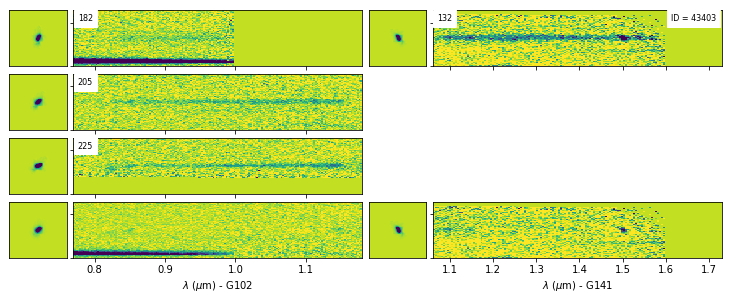

In [15]:
# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(
    wave=wave, 
    order=7,
    line=False)

pfit = mb.template_at_z(
    z=0, 
    templates=poly_templates, 
    fit_background=True, 
    fitter='lstsq', 
    fwhm=1400, 
    get_uncertainties=2)


hdu, fig = mb.drizzle_grisms_and_PAs(
    size=32, 
    fcontam=0.2, 
    flambda=False, 
    scale=1, 
    pixfrac=0.5, 
    kernel='point', 
    make_figure=True, 
    usewcs=False, 
    zfit=pfit,
    diff=True)
# Save drizzled ("stacked") 2D trace as PNG and FITS
fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)


### Generate the photometric catalog from the 3DHST catalog

In [16]:
print('GDS %i'%id_fit)
print('\tRA:', mb.ra)
print('\tDEC:', mb.dec)

print('Finding nearest source in 3DHST photometric catalog..')
phot, ii, dd = ep.get_phot_dict(mb.ra, mb.dec)

print('\tmatched source within %.5f arcsec'%dd.value)


GDS 43403
	RA: 53.256524993
	DEC: -27.707943411000006
Finding nearest source in 3DHST photometric catalog..
	matched source within 0.00148 arcsec


### Run the fit

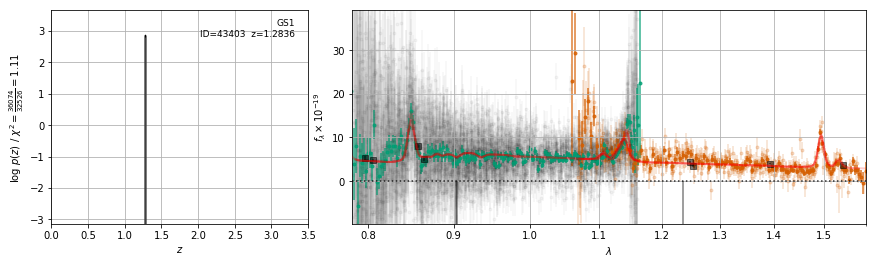

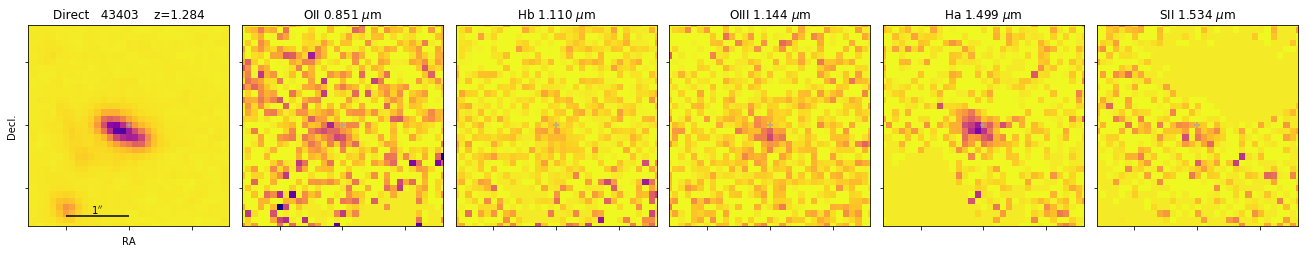

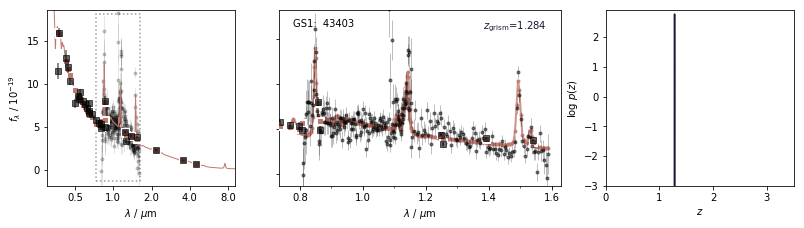

In [17]:
# The order of the polynomial used to scale the photometry to the spectrum
    # phot_scale_order = 0, multiplicative
    # phot_scale_order = 1, linear
    # phot_scale_order = 2, quadratic
    # etc.

phot_scale_order = 0

# run the fit
out = grizli.fitting.run_all(id_fit, 
                             t0=templ0, 
                             t1=templ1, 
                             fwhm=1200, 
                             zr=[0.0, 3.5], 
                             dz=[0.004, 0.0005], 
                             fitter='nnls',
                             group_name=field,
                             fit_stacks=True, 
                             prior=None, 
                             fcontam=0.,
                             pline=pline, 
                             mask_sn_limit=7, 
                             fit_only_beams=False,
                             fit_beams=True, 
                             root=field,
                             fit_trace_shift=False, 
                             phot=phot, 
                             verbose=False,                         
                             scale_photometry= phot_scale_order,   
                             show_beams=True)

<h1><center>Grizli products</center></h1>

### Stack of Grism orients

left columns:  G102

right columns: G141

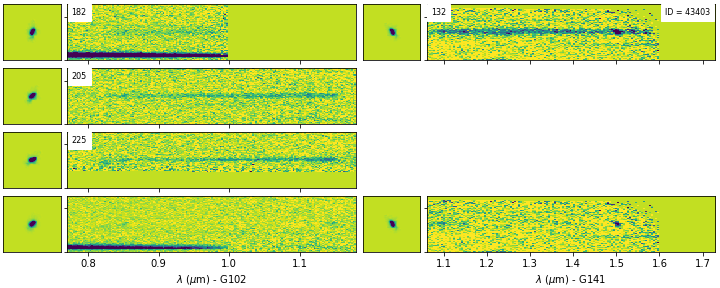

In [18]:
Image(filename = PATH_TO_PREP + '/GS1_43403.stack.png', width = 1000, height = 1000)

### SED fit

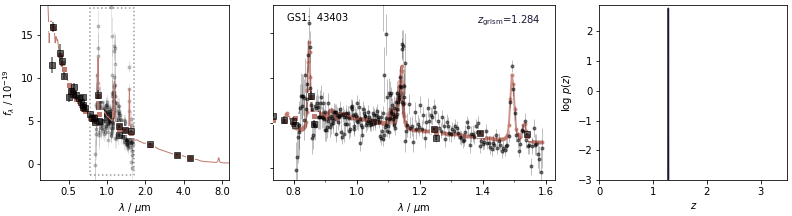

In [19]:
Image(filename = PATH_TO_PREP + '/GS1_43403.sed.png', width = 1000, height = 1000)

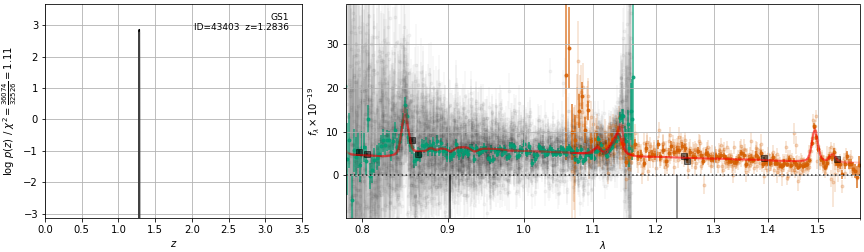

In [20]:
Image(filename = PATH_TO_PREP + '/GS1_43403.full.png', width = 1000, height = 1000)

### Emission line maps

GS1_43403.full.fits has lines [SII Ha OIII Hb OII]


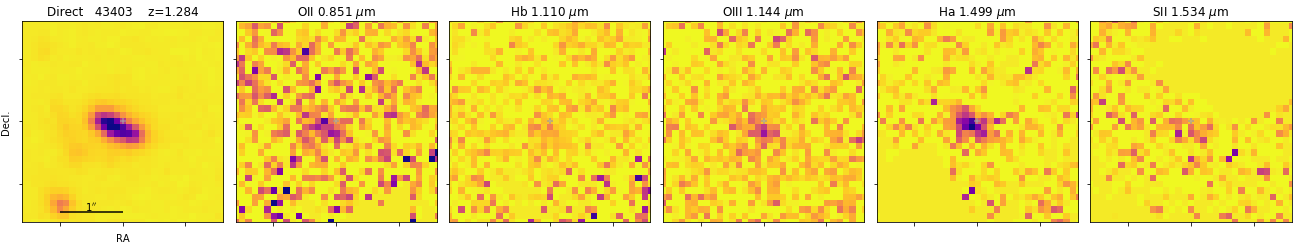

In [21]:
# Results of the fit are saved in *full.fits
fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))
# Helper script for plotting line maps, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
plt.close('all')

Image(filename = PATH_TO_PREP + '/GS1_43403.line.png', width = 1000, height = 1000)

### Fits files

In [22]:
fits_files = glob.glob('GS1_43403*fits')
for file in fits_files:
    im = fits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



GS1_43403.stack.fits


Filename: GS1_43403.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  SCI         G102,182.0 ImageHDU        66   (178, 64)   float32   
  2  WHT         G102,182.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,182.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,182.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,182.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102,205.0 ImageHDU        66   (178, 64)   float32   
  7  WHT         G102,205.0 ImageHDU        22   (178, 64)   float32   
  8  CONTAM      G102,205.0 ImageHDU        22   (178, 64)   float32   
  9  MODEL       G102,205.0 ImageHDU        24   (178, 64)   float32   
 10  KERNEL      G102,205.0 ImageHDU        22   (64, 64)   float32   
 11  SCI         G102,225.0 ImageHDU        66   (178, 64)   float32   
 12  WHT         G102,225.0 ImageHDU     

### The results of the fit are stored in *full.fits

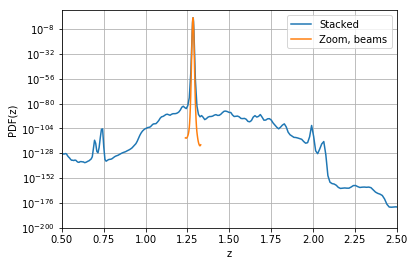

In [24]:
full_fits = fits.open('GS1_43403.full.fits')
zfit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


plt.plot(zfit_stack['zgrid'], zfit_stack['pdf'], label='Stacked')

# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   
plt.plot(fit_beam['zgrid'], fit_beam['pdf'], label='Zoom, beams')

plt.xlim(0.5, 2.5); plt.semilogy(); plt.grid()
plt.ylim(1.e-200, 1.e10)

plt.xlabel('z'); plt.ylabel('PDF(z)'); plt.legend()


### Results of the fit at the best determined redshift

odict_keys(['cont1d', 'line1d', 'cfit', 'coeffs', 'chi2', 'covar', 'z', 'templates'])
z = 1.2835705627997946
Continuum template, cont1d:  <class 'grizli.utils.SpectrumTemplate'>


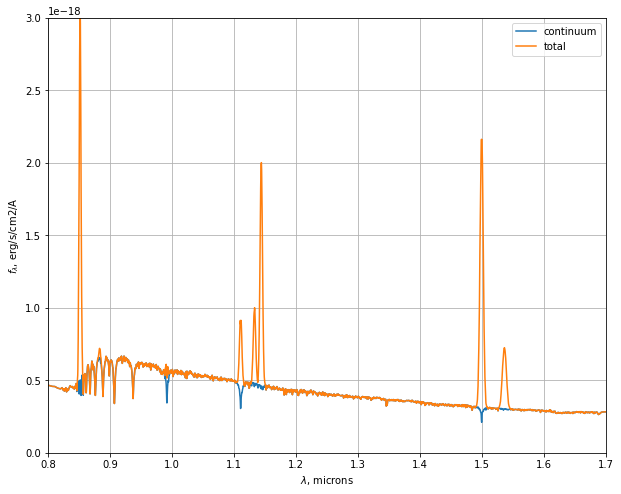

In [25]:
mb, st, fit, tfit, line_hdu = out

print(tfit.keys())
print('z = {0}'.format(tfit['z']))

print('Continuum template, cont1d: ', tfit['cont1d'].__class__)
fig, ax = plt.subplots(1,1, figsize = (10, 8))

ax.plot(tfit['cont1d'].wave/1.e4, tfit['cont1d'].flux, label='continuum')
ax.plot(tfit['line1d'].wave/1.e4, tfit['line1d'].flux, label='total')
ax.set_xlim(0.8, 1.7); ax.set_ylim(0,3.e-18); plt.grid()
ax.set_xlabel(r'$\lambda$, microns'); ax.set_ylabel(r'$f_\lambda$, erg/s/cm2/A'); plt.legend()

# cfit, coeffs, covar are coefficients of the template fit
# and their covariance


### 1D line fluxes

In [26]:
full_fits = fits.open('GS1_43403.full.fits')
full_hdr = full_fits[0].header
numlines = full_hdr['NUMLINES']


print ('%i lines detected'%numlines)
for n in np.arange(numlines):
    line_name = full_hdr['LINE%.3i'%(n+1)]
    line_flux = full_hdr['FLUX%.3i'%(n+1)]
    line_err  = full_hdr['ERR%.3i'%(n+1)]
    
    print ('\t\t\t' + line_name)
    print ('\t  flux =  %.2f'%(1.e17 * line_flux), 'x 10^-17 erg/s/cm^2')
    print ('\t eflux =  %.2f'%(1.e17 * line_err), 'x 10^-17 erg/s/cm^2')
    print ('\t\t flux/eflux =  %.1f'%(line_flux/line_err))

    print ('\n\n\n')




5 lines detected
			SII
	  flux =  3.38 x 10^-17 erg/s/cm^2
	 eflux =  0.88 x 10^-17 erg/s/cm^2
		 flux/eflux =  3.8




			Ha
	  flux =  12.52 x 10^-17 erg/s/cm^2
	 eflux =  0.70 x 10^-17 erg/s/cm^2
		 flux/eflux =  17.9




			OIII
	  flux =  10.17 x 10^-17 erg/s/cm^2
	 eflux =  0.66 x 10^-17 erg/s/cm^2
		 flux/eflux =  15.5




			Hb
	  flux =  2.78 x 10^-17 erg/s/cm^2
	 eflux =  0.42 x 10^-17 erg/s/cm^2
		 flux/eflux =  6.6




			OII
	  flux =  9.60 x 10^-17 erg/s/cm^2
	 eflux =  0.85 x 10^-17 erg/s/cm^2
		 flux/eflux =  11.3






In [27]:
full_hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                43403 / Object ID                                      
RA      =         53.256524993 / Central R.A.                                   
DEC     =   -27.70794341100001 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                   28 / Number of drizzled beams                       
FILE0001= 'ibhj01iqq_flt.fits' / Parent filename                                
GRIS0001= 'G141    '           / Beam grism element                             
PA0001  =                132

<h1><center>Batch-mode fitting</center></h1>

### Wrapper for fitting routines above

In [ ]:
def grizli_fit(grp, id_fit, field = '', ref_filter = 'F105W', use_pz_prior = True, use_phot = True, scale_phot = True, templ0 = None, templ1 = None, ep = None, pline = None):
    beams = grp.get_beams(id_fit, size=80)
    if beams != []:
        print("beams: ", beams)
        mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
        mb.write_master_fits()

        # Fit polynomial model for initial continuum subtraction
        wave = np.linspace(2000,2.5e4,100)
        poly_templates = grizli.utils.polynomial_templates(
            wave=wave, 
            order=7,
            line=False)

        pfit = mb.template_at_z(
            z=0, 
            templates=poly_templates, 
            fit_background=True, 
            fitter='lstsq', 
            fwhm=1400, 
            get_uncertainties=2)


        if pfit != None:
        # Drizzle grisms / PAs
            hdu, fig = mb.drizzle_grisms_and_PAs(
                size=32, 
                fcontam=0.2, 
                flambda=False, 
                scale=1, 
                pixfrac=0.5, 
                kernel='point', 
                make_figure=True, 
                usewcs=False, 
                zfit=pfit,
                diff=True)
            # Save drizzled ("stacked") 2D trace as PNG and FITS
            fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
            hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



            if use_pz_prior:
                #use redshift prior from z_phot
                prior = np.zeros((2, len(p.tempfilt['zgrid'])))
                prior[0] = p.tempfilt['zgrid']
                prior[1] = p.pz['chi2fit'][:,id]
            else:
                prior = None 
            order = 0



            tab = utils.GTable()
            tab['ra'] = [mb.ra]
            tab['dec'] = [mb.dec]

            tab['id'] = id_fit
            phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
            out = grizli.fitting.run_all(
                id_fit, 
                t0=templ0, 
                t1=templ1, 
                fwhm=1200, 
                zr=[0.0, 3.5], 
                dz=[0.004, 0.0005], 
                fitter='nnls',
                group_name=field,
                fit_stacks=True, 
                prior=None, 
                fcontam=0.,
                pline=pline, 
                mask_sn_limit=7, 
                fit_only_beams=False,
                fit_beams=True, 
                root=field,
                fit_trace_shift=False, 
                phot=phot, 
                verbose=True, 
                scale_photometry=order, 
                show_beams=True)
            mb, st, fit, tfit, line_hdu = out
            fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

            fit_hdu.info()
            # same as the fit table above, redshift fit to the stacked spectra
            fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


            # zoom in around the initial best-guess with the individual "beam" spectra
            fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

            templ = Table(fit_hdu['TEMPL'].data)
            print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

            # Helper script for plotting them, not generated automatically
            fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
            fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
            plt.close('all')



### Fitting every object in the field with jh mag < 22

In [ ]:
#Fit all objects with MAG_AUTO < 22
if False:
    good = np.where(np.array(grp.catalog['MAG_AUTO']) < 22)[0]
    for g in good:
        id_fit = np.array(grp.catalog['NUMBER'])[g]
        mag_fit = grp.catalog['MAG_AUTO'][g]
        grizli_fit(grp, id_fit = id_fit, field = field,
                   use_pz_prior = False, use_phot = True, scale_phot = True,
                   templ0 = templ0, templ1 = templ1, ep = ep, pline = pline,)
        


In [ ]:
'''
x = templ1['fsps/fsps_QSF_12_v3_nolines_002.dat']

fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(x.wave, x.flux)
ax.semilogx()
ax.set_xlim(4000, 7000)
'''